#### Setup
The data is imported and pre-processed.

I map the data in "y" so Malignant is tracked as "1" and Benign is tracked as "0"

I drop unused Columns

I create a test/train split for initial data exploration 


In [1]:
# Import necessary libraries
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import NearestNeighbors


# Load the breast cancer dataset
data = pd.read_csv('data/cancer_data.csv')



In [2]:

#map the data in "y" so Malignant is tracked as "1" and Benign is tracked as "0"
y = data['diagnosis']
y = y.map({'M': 1, 'B': 0})

#drop the raget variable, and other un-suiteed columns from X
list = ['Unnamed: 32','id','diagnosis']
X = data.drop(list,axis = 1 )

print(X.info())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

## Data Review
There are no null/NA rows, and the entire dataset is numeric. Standard scaling can be applied to all variables

I added GMM clustering and DBscan labels as well


In [3]:
# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Step 2: Apply Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Step 3: Add GMM cluster labels as a feature to the dataset
X['gmm_cluster'] = gmm_labels

# Step 4: Apply DBSCAN to detect outliers
dbscan = DBSCAN(eps=2.7, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Step 5: Add DBSCAN labels to the dataset (outliers will have a label of -1)
X['dbscan_cluster'] = dbscan_labels



# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


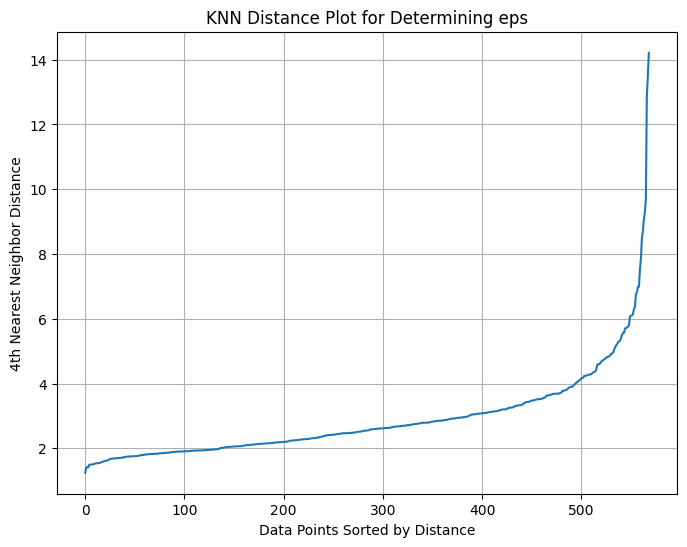

In [4]:
# Create a NearestNeighbors model to compute distances to the nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances and plot
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('KNN Distance Plot for Determining eps')
plt.grid(True)
plt.show()

## Initial Clustering Evaluation

Since the goal is to conduct a binary evaluation, GMM was fairly straight forward to set to 2, expecting there to be 2 clusters 

DB-scan was more complicated. The Above plot show the distribution of the data, with the "Elbow point" being selected as the ideal value for Epsilon 

As will be shown below, the addition of these clusters shifted performance, often actually degrading performance of the models. Additional work could be done to further explore the clustering space to see if it could improve model performance


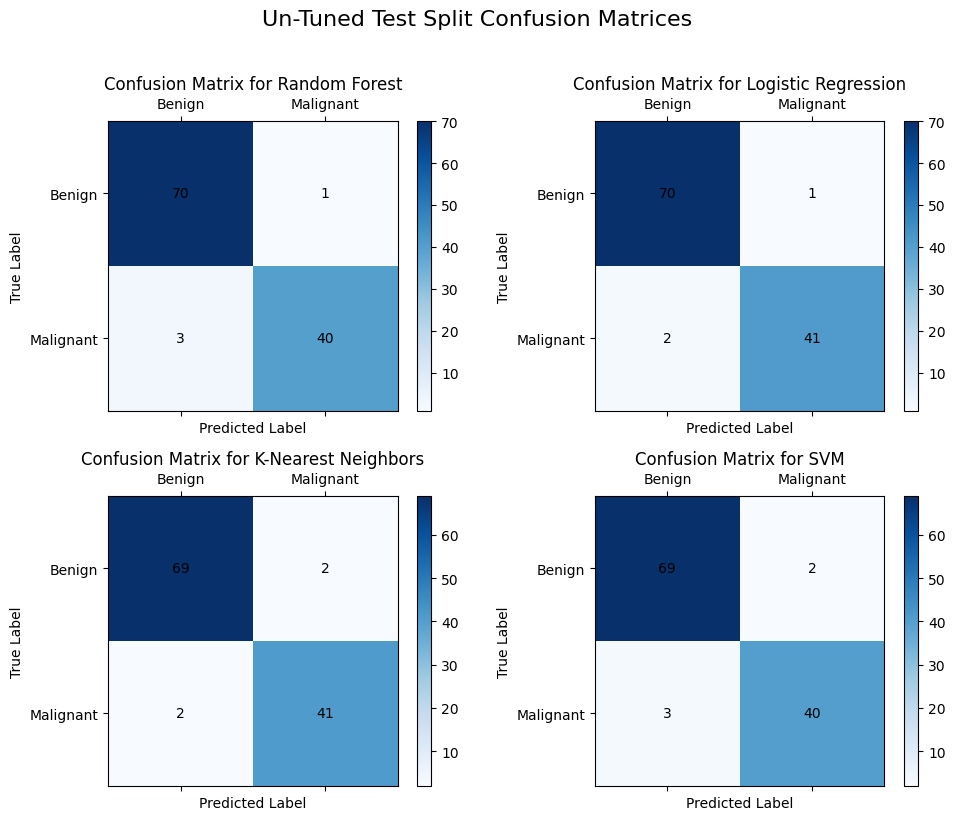

In [5]:
# List of classifiers to explore
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}


def plot_confusion_matrix(cm, classifier_name, ax):
    # Plot the confusion matrix on the given axes (ax) object
    cax = ax.matshow(cm, cmap='Blues')
    
    # Add a color bar to the plot
    plt.colorbar(cax, ax=ax)

    # Set up axes ticks and labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Benign', 'Malignant'])
    ax.set_yticklabels(['Benign', 'Malignant'])

    # Label axes and set title directly on the subplot axes
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix for {classifier_name}')

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")

    
#initialize a dictionary to store the accuraciese
accuracies = {}
#initialize a list to store confusion matrixes
confusion_matrices = []
titles = []

# Iterate over classifiers and evaluate each
for name, classifier in classifiers.items():
    # Create the pipeline with StandardScaler and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Preprocessing step: standardization
        ('classifier', classifier)     # Classifier step
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
     # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)
    titles.append(name)
    
    # Save the results
    accuracies[name] = accuracy
    # Plot the confusion matrix using the custom function

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each confusion matrix using the updated function in its corresponding subplot
for i, ax in enumerate(axes):
    plot_confusion_matrix(confusion_matrices[i], classifier_name=titles[i], ax=ax)

fig.suptitle('Un-Tuned Test Split Confusion Matrices', fontsize=16, y=1.02)


plt.tight_layout()  # Adjust the spacing between plots for a clean look
plt.show()




The Initial Analysis was to run a simple version of these models without any tuning or classification. This produced the following results:
- 'SVM': 0.9825
- 'Logistic Regression': 0.9737
- 'Random Forest': 0.9649
- 'K-Nearest Neighbors': 0.9473

The performance here was already incredibly strong, with SVM performing the best. I rerun the same analysis, including my GMM and DBSCAN cluster, and the changes in performance were surprising: 
- Logistic Regression: 0.9737 -> same 
- Random Forest: 0.9649 -> same performance
- K-Nearest Neighbors: 0.9649 -> improved
- SVM: 0.95614 -> regressed



### Model Evaluation and Exploration: 

I created many different version of this model, all graded on GridSearchCV with 5 folds. After some initial testing I landed on the param_grid below. 

I looked at the 4 models under investigation in each of the following circumstances:
- GridSearchCV, including both clustering labels shown above
- GridSearchV, including both clustering labels and polynomial degree = 2
- GridSearchV, including both clustering labels and polynomial degree = 3
- GridSearchCV, excluding clustering labels and polynomial degree =2
  


Best hyperparameters for Random Forest: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 50}
Mean Recall from 5-Fold CV: 0.9249

Best hyperparameters for Logistic Regression: {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 1, 'classifier__penalty': 'l2'}
Mean Recall from 5-Fold CV: 0.9482

Best hyperparameters for K-Nearest Neighbors: {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Mean Recall from 5-Fold CV: 0.934

Best hyperparameters for SVM: {'classifier': SVC(random_state=42), 'classifier__C': 10, 'classifier__kernel': 'linear'}
Mean Recall from 5-Fold CV: 0.9576


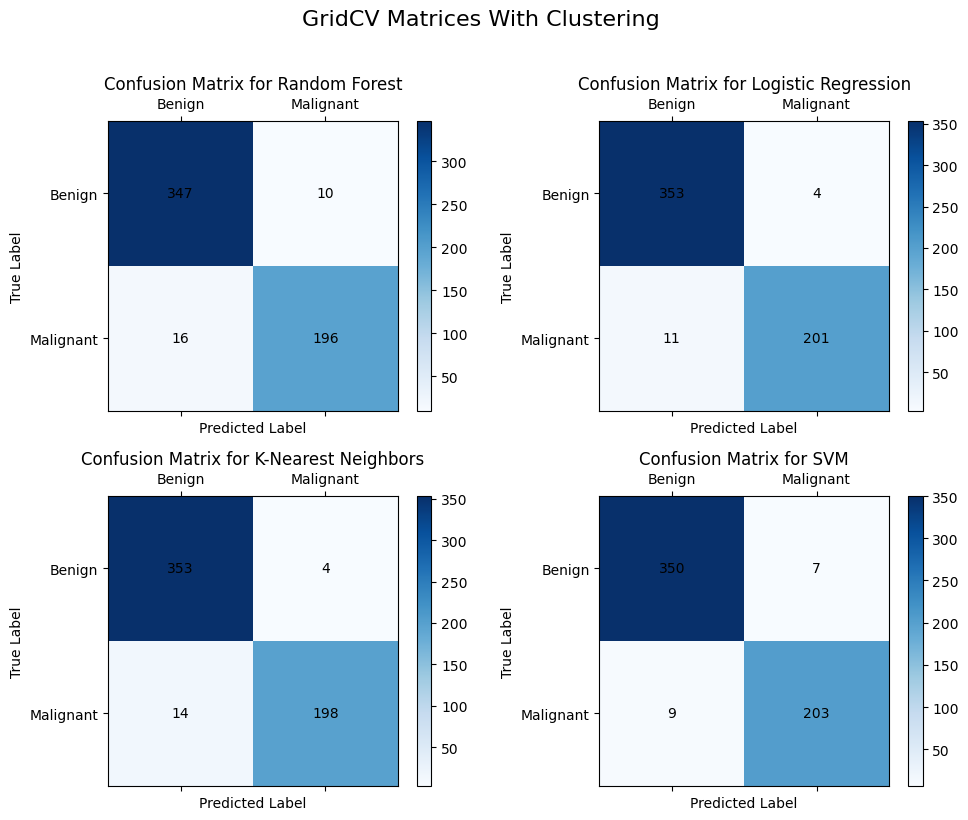

In [6]:
#Set up the classifiers and their corresponding parameter grids
param_grid = {
    'Random Forest': {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
    },
    'Logistic Regression': {
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    'K-Nearest Neighbors': {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'SVM': {
        'classifier': [SVC(random_state=42)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}


#Reset the variables
accuracies = {}
titles = []
confusion_matrices = []

# Iterate over classifiers and tune hyperparameters using GridSearchCV
for name, params in param_grid.items():
    # Create the pipeline with StandardScaler and a placeholder classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Preprocessing step: standardization
        ('classifier', RandomForestClassifier())  # Placeholder for classifier
    ])

    # Set up GridSearchCV with the current classifier's parameter grid and 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='recall')

    # Fit the GridSearchCV model to find the best hyperparameters using cross-validation
    grid_search.fit(X, y)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

    # Since we used cross-validation, we'll evaluate the performance using cross-validation scores
    cv_results = cross_val_score(best_model, X, y, cv=5, scoring='recall')

    # Output the results
    print(f"\nBest hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Mean Recall from 5-Fold CV: {cv_results.mean():.4}")
    
    #Create a confusion matrix for further insights
    y_pred_all = cross_val_predict(best_model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred_all)

    confusion_matrices.append(conf_matrix)
    titles.append(name)
    
    # Save the results
    accuracies[name] = accuracy
    # Plot the confusion matrix using the custom function

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each confusion matrix using the updated function in its corresponding subplot
for i, ax in enumerate(axes):
    plot_confusion_matrix(confusion_matrices[i], classifier_name=titles[i], ax=ax)

fig.suptitle('GridCV Matrices With Clustering', fontsize=16, y=1.02)

plt.tight_layout() 
plt.show()


## Analysis
The above plots show a fairly tight grouping of Recall across the different Models, with SVM performaing the best on Recall, with no negative effects on accuracy. 

Next I included polynomial combinations of the features of degree = 2


Tuning hyperparameters for Random Forest...

Best hyperparameters for Random Forest: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 50}
Mean Recall from 5-Fold CV: 0.9435

Tuning hyperparameters for Logistic Regression...

Best hyperparameters for Logistic Regression: {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Mean Recall from 5-Fold CV: 0.9482

Tuning hyperparameters for K-Nearest Neighbors...

Best hyperparameters for K-Nearest Neighbors: {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Mean Recall from 5-Fold CV: 0.9341

Tuning hyperparameters for SVM...

Best hyperparameters for SVM: {'classifier': SVC(random_state=42), 'classifier__C': 10, 'classifier__kernel': 'rbf'}
Mean Recall from 5-Fold CV: 0.9576


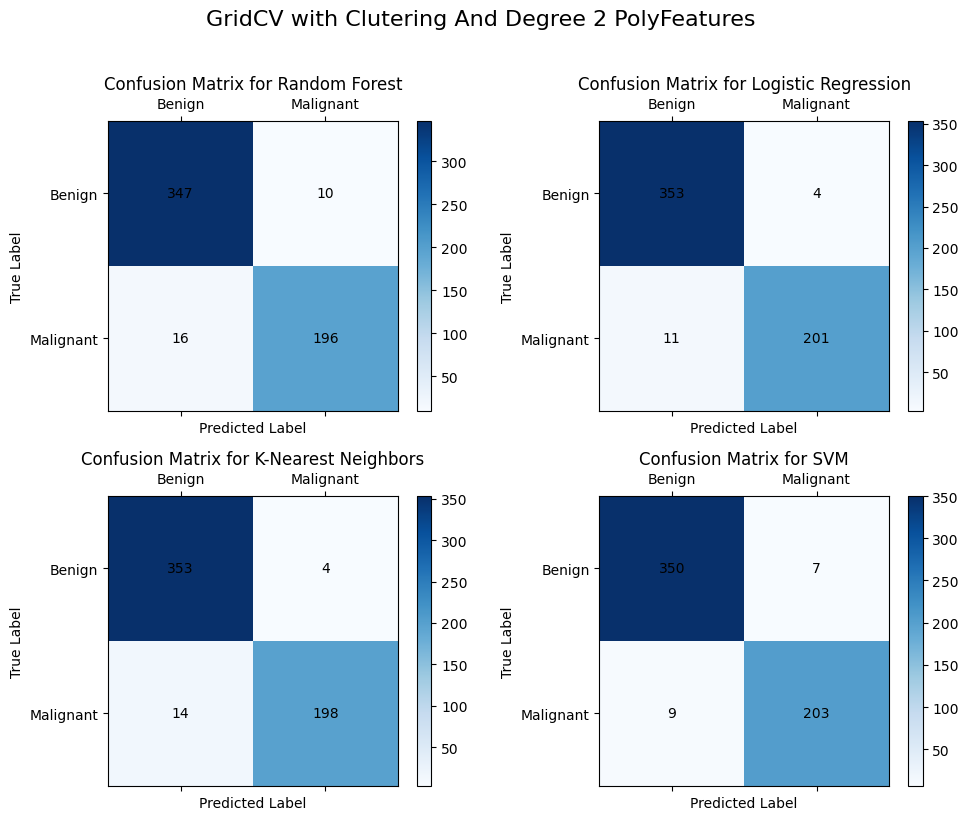

In [7]:
#Repeat of the above, including poly features of degree = 2


# Iterate over classifiers and tune hyperparameters using GridSearchCV
best_estimators = {}
for name, params in param_grid.items():
    print(f"\nTuning hyperparameters for {name}...")
    # Create the pipeline with StandardScaler and a placeholder classifier
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
        ('scaler', StandardScaler()),  # Optional step for scaling
        ('classifier', RandomForestClassifier())  # Replace with the model of your choice
    ])

    # Set up GridSearchCV with the current classifier's parameter grid
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='recall')

     # Fit the GridSearchCV model to find the best hyperparameters using cross-validation
    grid_search.fit(X, y)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

     # Store the best estimator in the dictionary
    best_estimators[name] = best_model
    
    # Since we used cross-validation, we'll evaluate the performance using cross-validation scores
    cv_results = cross_val_score(best_model, X, y, cv=5, scoring='recall')

    # Output the results
    print(f"\nBest hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Mean Recall from 5-Fold CV: {cv_results.mean():.4}")
    
    y_pred_all = cross_val_predict(best_model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred_all)

    # Save the results
    confusion_matrices.append(conf_matrix)
    titles.append(name)
    
    accuracies[name] = accuracy

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each confusion matrix using the updated function in its corresponding subplot
for i, ax in enumerate(axes):
    plot_confusion_matrix(confusion_matrices[i], classifier_name=titles[i], ax=ax)

fig.suptitle('GridCV with Clutering And Degree 2 PolyFeatures', fontsize=16, y=1.02)


plt.tight_layout()  # Adjust the spacing between plots for a clean look
plt.show()


## Analaysis

Adding Polynomial Features of degree = 2 strictly improved the model. This seemed to be an extremely valuable edition. 

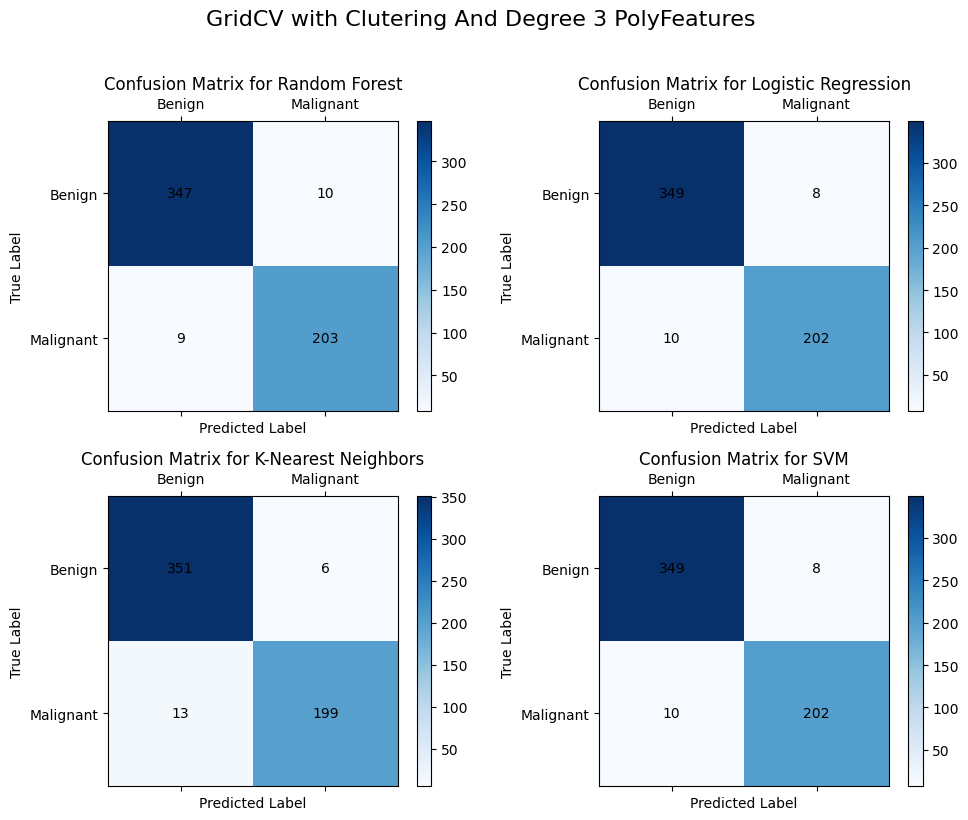

In [8]:
#Repeat of the above, including poly features of degree = 3

#Reset the variables
accuracies = {}
titles = []
confusion_matrices = []

# Iterate over classifiers and tune hyperparameters using GridSearchCV
for name, params in param_grid.items():

    # Create the pipeline with StandardScaler and a placeholder classifier
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)),
        ('scaler', StandardScaler()),  # Optional step for scaling
        ('classifier', RandomForestClassifier())  # Replace with the model of your choice
    ])

    # Set up GridSearchCV with the current classifier's parameter grid
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='recall')

     # Fit the GridSearchCV model to find the best hyperparameters using cross-validation
    grid_search.fit(X, y)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

    # Since we used cross-validation, we'll evaluate the performance using cross-validation scores
    cv_results = cross_val_score(best_model, X, y, cv=5, scoring='recall')

    # Optionally, you could refit on the entire data and create a confusion matrix for further insights
    y_pred_all = cross_val_predict(best_model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred_all)

     # Save the results
    confusion_matrices.append(conf_matrix)
    titles.append(name)
    
    accuracies[name] = accuracy

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each confusion matrix using the updated function in its corresponding subplot
for i, ax in enumerate(axes):
    plot_confusion_matrix(confusion_matrices[i], classifier_name=titles[i], ax=ax)

fig.suptitle('GridCV with Clutering And Degree 3 PolyFeatures', fontsize=16, y=1.02)


plt.tight_layout()  # Adjust the spacing between plots for a clean look
plt.show()


Adding a third degree Polynomial feature significnatly increased the model training time, and  has no impact on Recall while actually degrading performace on Accuracy in some cases. Potential continuing work could be done to try to tune to Polynomial features and clustering mechanisms which were not able to significantly improve performance of the model overall


Best hyperparameters for Random Forest: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 100}
Mean Recall from 5-Fold CV: 0.9625

Best hyperparameters for Logistic Regression: {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Mean Recall from 5-Fold CV: 0.9575

Best hyperparameters for K-Nearest Neighbors: {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Mean Recall from 5-Fold CV: 0.9386

Best hyperparameters for SVM: {'classifier': SVC(random_state=42), 'classifier__C': 10, 'classifier__kernel': 'rbf'}
Mean Recall from 5-Fold CV: 0.9623


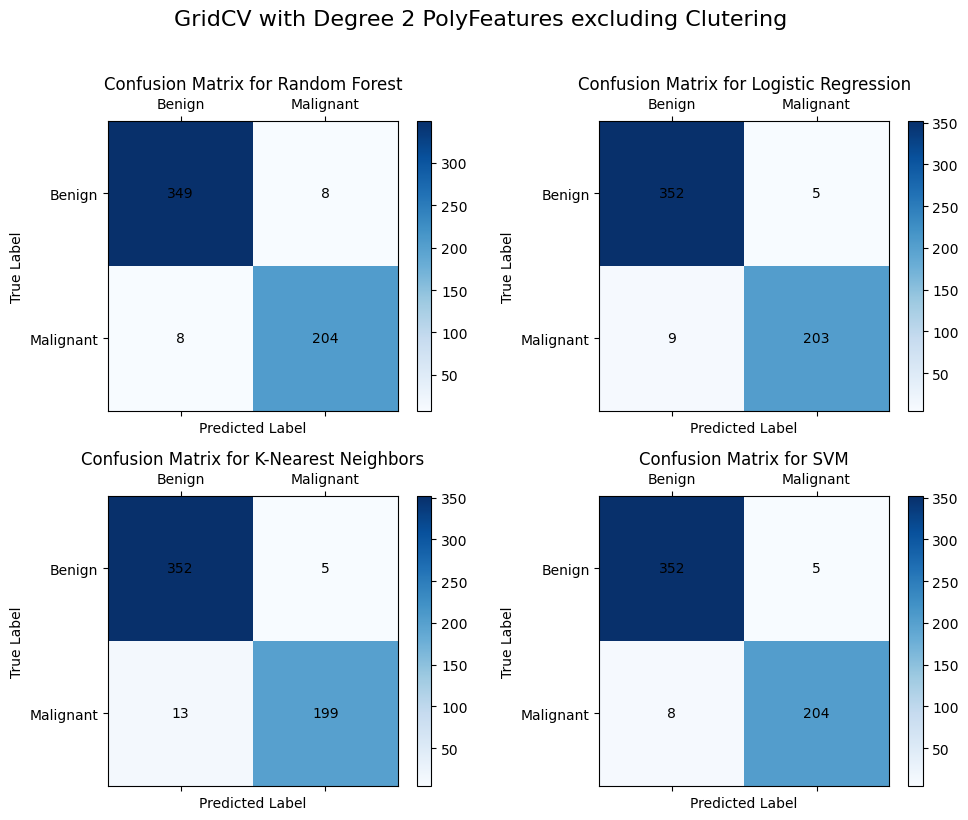

In [9]:
#Repeat of the above, including poly features of degree = 2, excluding the clustering models
# Load the breast cancer dataset
data = pd.read_csv('data/cancer_data.csv')

#map the data in "y" so Malignant is tracked as "1" and Benign is tracked as "0"
y = data['diagnosis']
y = y.map({'M': 1, 'B': 0})

#drop the raget variable, and other un-suiteed columns from X
list = ['Unnamed: 32','id','diagnosis']
X = data.drop(list,axis = 1 )


#Reset the variables
accuracies = {}
titles = []
confusion_matrices = []
best_estimators = {}

# Iterate over classifiers and tune hyperparameters using GridSearchCV
for name, params in param_grid.items():

    # Create the pipeline with StandardScaler and a placeholder classifier
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
        ('scaler', StandardScaler()),  # Optional step for scaling
        ('classifier', RandomForestClassifier())  # Replace with the model of your choice
    ])

    # Set up GridSearchCV with the current classifier's parameter grid
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='recall')

     # Fit the GridSearchCV model to find the best hyperparameters using cross-validation
    grid_search.fit(X, y)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

     # Store the best estimator in the dictionary
    best_estimators[name] = best_model
    
    # Since we used cross-validation, we'll evaluate the performance using cross-validation scores
    cv_results = cross_val_score(best_model, X, y, cv=5, scoring='recall')

    # Output the results
    print(f"\nBest hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Mean Recall from 5-Fold CV: {cv_results.mean():.4}")
    
    # Optionally, you could refit on the entire data and create a confusion matrix for further insights
    y_pred_all = cross_val_predict(best_model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred_all)

    # Save the results
    confusion_matrices.append(conf_matrix)
    titles.append(name)
    
    accuracies[name] = accuracy

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each confusion matrix using the updated function in its corresponding subplot
for i, ax in enumerate(axes):
    plot_confusion_matrix(confusion_matrices[i], classifier_name=titles[i], ax=ax)


fig.suptitle('GridCV with Degree 2 PolyFeatures excluding Clutering', fontsize=16, y=1.02)

plt.tight_layout()  # Adjust the spacing between plots for a clean look
plt.show()


### Feature Importance

Since the Optimal hyper-parameters fpr the SMV model include an RBF kernel which is not trivial to visualize feature importance, and K-nearest Neighbors is not possible to visualize in the same way, I visualize only LinReg and Random Forest, even though the Random Forest model performs substantially worse. 

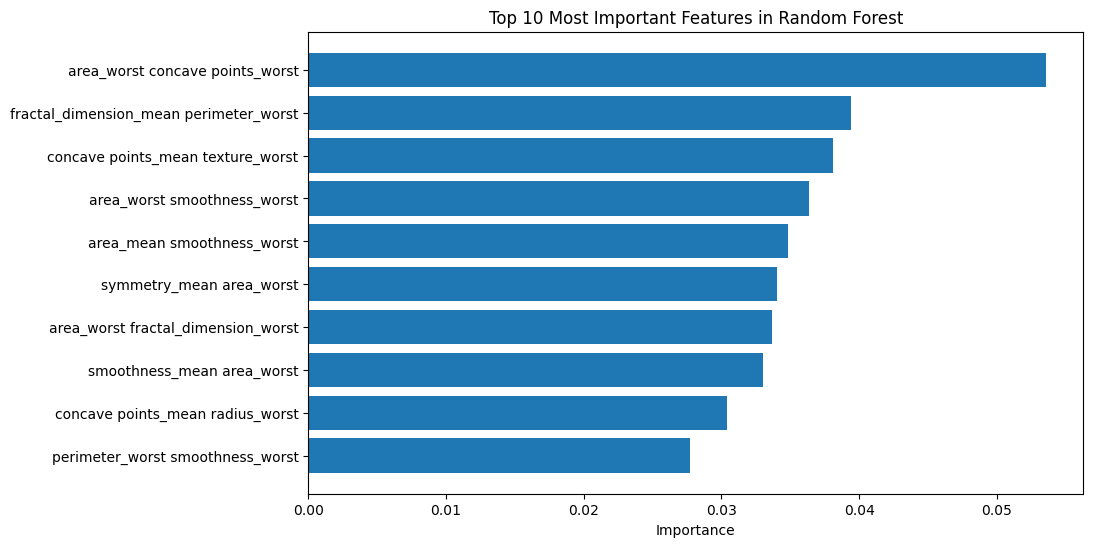

In [10]:

# Get the original feature names 
original_feature_names = X.columns  

rf_model = best_estimators['Random Forest']
# Generate feature names for polynomial features (degree=2 in this case)
poly = rf_model.named_steps['poly']  # Assuming this is the PolynomialFeatures step from the pipeline
polynomial_feature_names = poly.get_feature_names_out(original_feature_names)

# Get feature importances from the random forest model
rf_model = best_estimators['Random Forest']
importances = rf_model.named_steps['classifier'].feature_importances_

# Get the indices of the top 10 most important features
indices = np.argsort(importances)[-10:]

# Create a bar plot of the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(indices)), importances[indices], align='center')
plt.yticks(np.arange(len(indices)), [polynomial_feature_names[i] for i in indices])  # Use polynomial feature names
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features in Random Forest')
plt.show()


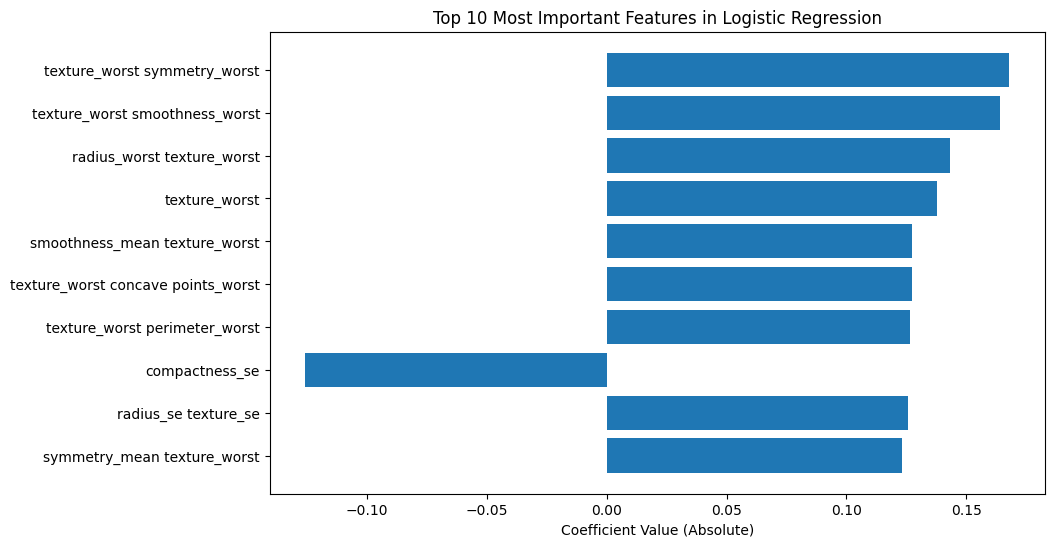

In [11]:

logreg_model = best_estimators['Logistic Regression']

# Access the polynomial feature names
poly = logreg_model.named_steps['poly']  # Access the PolynomialFeatures step
polynomial_feature_names = poly.get_feature_names_out(original_feature_names)

# Get coefficients from the logistic regression model
coefs = logreg_model.named_steps['classifier'].coef_.flatten()

# Get the indices of the top 10 most important features (by absolute value)
indices = np.argsort(np.abs(coefs))[-10:]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(indices)), coefs[indices], align='center')
plt.yticks(np.arange(len(indices)), [polynomial_feature_names[i] for i in indices])  # Use polynomial feature names
plt.xlabel('Coefficient Value (Absolute)')
plt.title('Top 10 Most Important Features in Logistic Regression')
plt.show()



### Conclusion: 

- The strictly best performing model, is the SVM with Degree = 3 PolynomialFeatures and both clustering algorithms applied. However, due to the size of the data set, this is at a high risk of over-fit
- The best trade off in Model Performance was the Degree = 2 PolynomialFeatures without clustering labels applied. This model had a Mean Recall from 5-Fold CV of 0.9623. This number would likely need to be improved in order to
- Logistic Regression performed just as well in Recall department, but slightly worse in accuracy. However, Logistic Regression is a much easier to interpret model, gicing us clear feature scores. It's very clear from the top 10 feature values on display above that texture_worst is the most important singular feature. If interperitability were a key goal, Logistic Regression Model would be superios. 



### Continuing Work: 

- I was surprised and disappointed that I was unable to use clustering to improve the model performance. Theoretically this should be possible. Additional experimentation with hyper parameters, as well as potentially reducing the dimensionality could yield valuable results 
- The biggest flaw in this dataset was simply its size. With targets of recall so high for the realworld application, It's hard to imaging exceeding 99% accuracy without a larger dataset.
- Ensemble Techniques like XGBoost, Gradient Boosting Machines, or Random Forest might help with further reducing False Negatives
- Expanding the ParamGrid to search a broader space for potentially more optimal hyper-perameters. 